# Portfolio Optimization With Finance Theory

## Code - Main calss

In [1]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import random
from typing import Union, Dict, List, Tuple
import logging
logging.basicConfig(filename='portfolio.log', level=logging.ERROR)


class Portfolio:
    """
    A class for portfolio optimization and analysis.

    Args:
      data (pd.DataFrame): DataFrame with historical asset prices.
      return_calc (str): Accepts either 'log' or 'simple' as the method to compute returns (default is log).
      intervals (int, optional): Number of trading intervals per year (default is 252).
      risk_free_rate (float, optional): Risk-free rate used for calculations (default is 0).
      minimum_weight (float, optional): Minimum weight for assets in the portfolio (default is 0).
      mult (float): multiplier of max sharp return to limit the frontier (default is 1.2).

    Attributes:
      data (pd.DataFrame): Historical asset price data.
      mean_returns (pd.Series): Mean returns for each asset.
      cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
      num_assets (int): Number of assets in the portfolio.
      intervals (int): Number of trading intervals per year.
      risk_free_rate (float): Risk-free rate used for calculations.
      minimum_weight (float): Minimum weight for assets in the portfolio.
    """

    def __init__(self, data, intervals=252, risk_free_rate=0, minimum_weight=0, return_calc='log', mult=1.2):
        self.return_calc = return_calc
        self.data = data
        self.mean_returns, self.cov_matrix = self.initial_process()
        self.num_assets = len(self.mean_returns)
        self.intervals = intervals
        self.risk_free_rate = risk_free_rate
        self.minimum_weight = minimum_weight
        self.mult = mult
        
    def initial_process(self) -> Tuple[pd.Series, pd.DataFrame]:
        """
        Perform initial data processing to calculate mean returns and the covariance matrix.

        Returns:
            Tuple[pd.Series, pd.DataFrame]: Mean returns and covariance matrix.
        """
        try:
            if not isinstance(self.data, pd.DataFrame) or self.data.empty:
                raise ValueError("Input data must be a non-empty DataFrame.")

            if self.return_calc == 'simple':
                returns = self.data.pct_change()
            elif self.return_calc == 'log':
                returns = np.log(self.data / self.data.shift(1))

            return returns.mean(), returns.cov()

        except Exception as e:
            logging.error(f"Error during initialization: {str(e)}")


    def portfolio_return(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the portfolio return.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Portfolio return.
        """
        try:
            if not isinstance(weights, (list, np.ndarray)) or len(weights) != self.num_assets:
                raise ValueError("Portfolio weights must be a list or numpy array of the same length as the number of assets.")
            return np.sum(self.mean_returns * weights) * self.intervals # transform into annually return

        except Exception as e:
            logging.error(f"Error in portfolio_return: {str(e)}")


    def portfolio_std(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the portfolio standard deviation.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Portfolio standard deviation.
        """
        try:
            if not isinstance(weights, (list, np.ndarray)) or len(weights) != self.num_assets:
                raise ValueError("Portfolio weights must be a list or numpy array of the same length as the number of assets.")
            return np.sqrt( np.dot(weights.T, np.dot(self.cov_matrix, weights)) ) * np.sqrt(self.intervals) #transform into annually variance

        except Exception as e:
            logging.error(f"Error in portfolio_std: {str(e)}")

    def get_neg_sharp_ratio(self, weights: Union[List[float], np.ndarray]) -> float:
        """
        Calculate the negative Sharpe ratio of the portfolio.

        Args:
            weights (List[float] or np.ndarray): Portfolio asset weights.

        Returns:
            float: Negative Sharpe ratio.
        """
        p_returns = self.portfolio_return(weights)
        p_std = self.portfolio_std(weights)
        return - (p_returns - self.risk_free_rate) / p_std

    def max_sharp_ratio_portfolio(self) -> minimize:
        """
        Find the portfolio with the maximum Sharpe ratio.

        Returns:
            minimize: Result of the optimization.
        """
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (self.minimum_weight, 1)
        bounds = tuple(bound for asset in range(self.num_assets))
        result = minimize(self.get_neg_sharp_ratio,
                          self.num_assets*[1./self.num_assets],
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)#,options={'ftol': 1e-4, 'eps': 1e-4})

        if not result['success']:
            logging.error(f"Error in max_sharp_ratio_portfolio: {result['message']}")

        return result


    def min_var_portfolio(self, target_return: float = None) -> minimize:
        """
        Find the minimum variance portfolio.

        Args:
            target_return (float, optional): Target portfolio return for a specific portfolio (default is None).

        Returns:
            minimize: Result of the optimization.
        """

        if target_return:
            constraints = (
                           {'type':'eq','fun': lambda x: self.portfolio_return(x) - target_return},
                           {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                          )
        else:
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})


        bound = (self.minimum_weight, 1)
        bounds = tuple(bound for asset in range(self.num_assets))
        result = minimize(self.portfolio_std,
                          self.num_assets*[1./self.num_assets],
                          method='SLSQP',
                          bounds=bounds,
                          options={'maxiter':500},
                          constraints=constraints)

        if not result['success']:
            logging.error(f"Error in min_var_portfolio: {result['message']}")

        return result

    def get_efficient_frontier(self) -> Tuple[float, float, pd.DataFrame, float, float, pd.DataFrame, List[float], List[float]]:
        """
        Calculate the efficient frontier and key portfolios.

        Returns:
            Tuple[float, float, pd.DataFrame, float, float, pd.DataFrame, List[float], List[float]:
                - Maximum Sharpe ratio portfolio return, standard deviation, and allocation.
                - Minimum volatility portfolio return, standard deviation, and allocation.
                - List of portfolio standard deviations for the efficient frontier.
                - List of target returns for the efficient frontier.
        """

        # Max Sharpe Ratio Portfolio
        max_sharp_portfolio = self.max_sharp_ratio_portfolio()
        max_sharp_returns = self.portfolio_return(max_sharp_portfolio['x'])
        max_sharp_std = self.portfolio_std(max_sharp_portfolio['x'])
        max_sharp_allocation = pd.DataFrame(max_sharp_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])

        # Min Volatility Portfolio
        min_vol_portfolio = self.min_var_portfolio()
        min_vol_returns = self.portfolio_return(min_vol_portfolio['x'])
        min_vol_std = self.portfolio_std(min_vol_portfolio['x'])
        min_vol_allocation = pd.DataFrame(min_vol_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])

        # Efficient Frontier
        efficient_frontier_list = []

        target_return_list = np.linspace(min_vol_returns, max_sharp_returns*self.mult, 50)
        for target in target_return_list:
            efficient_frontier_list.append(self.min_var_portfolio(target_return=target)['fun'])

        return max_sharp_returns, max_sharp_std, max_sharp_allocation, min_vol_returns, min_vol_std, min_vol_allocation, efficient_frontier_list, target_return_list


    def simulate_portfolios(self, max_r: float, max_std: float, trials: int = 5000) -> Tuple[List[float], List[float], List[List[float]]]:
        """
        Simulate random portfolios with specified constraints.

        Args:
            max_r (float): Maximum allowed return.
            max_std (float): Maximum allowed standard deviation.
            trials (int, optional): Number of portfolio simulations (default is 5000).

        Returns:
            Tuple[List[float], List[float], List[List[float]]:
                - List of portfolio returns.
                - List of portfolio standard deviations.
                - List of portfolio weightings.
        """

        returns, stds, results = [], [], []
        for _ in tqdm(range(trials)):
            # Generate random weights
            weights = np.random.exponential(scale=0.5, size=self.num_assets)
            
            # Randomly select indices to change to minimum weigh
            indices_to_change = random.sample(range(len(weights)), np.random.randint(1, int(len(weights)*0.8)))
            
            # Create a new list with elements changed to minimum weight
            weights = [self.minimum_weight if i in indices_to_change else elem for i, elem in enumerate(weights)]
            
            # Normalize to ensure the weights sum to 1
            weights /= np.sum(weights)
            
            # Get retrun and std
            p_return = self.portfolio_return(weights)
            p_std = self.portfolio_std(weights)
            
            # Make limits of maximum retruns and std
            if p_return > max_r or p_std > max_std:
                pass
            else:
                returns.append(p_return)
                stds.append(p_std)
                results.append(weights)
        return returns, stds, results


    def create_cml(self, max_sharp_return: float, max_sharp_std: float, max_leverage=2.0):
        """
        Create a Capital Market Line (CML) by combining the given maximum Sharpe ratio return and standard deviation.

        Args:
            max_sharp_return (float): The maximum Sharpe ratio return.
            max_sharp_std (float): The standard deviation corresponding to the maximum Sharpe ratio.
            max_leverage (float): The maximum leverage that allowed (default is 200% )
        """
        self.cml = {'returns':[], 'stds':[], 'leverage_returns':[], 'leverage_stds':[]}

        for i in np.linspace(0, max_leverage, 60):
            Wp = i
            Wrf = 1-Wp
            if i <= 1:
                self.cml['returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
                self.cml['stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
            else:
                self.cml['leverage_returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
                self.cml['leverage_stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0


    # Could be outside from the class
    def plot_efficient_frontier(self, with_cml=False) -> go.Figure:
        """
        Plot the efficient frontier and portfolio optimization results.

        Returns:
            go.Figure: Plotly figure displaying the efficient frontier.
        """
        # Get the Efficient Frontier data
        max_sharp_returns, max_sharp_std, _, min_vol_returns, min_vol_std, _, efficient_frontier_list, target_return_list = self.get_efficient_frontier()

        # Get the CML (Capital Market Line) data
        self.create_cml(max_sharp_returns, max_sharp_std)

        # Get the random combination portfolios
        returns, stds, _ = self.simulate_portfolios(max_r=max_sharp_returns*1.5, max_std=max_sharp_std*1.5)

        # Efficient Frontier portfolios
        EfficientFrontier = go.Scatter(
            name='Efficient Frontier',
            mode='lines',
            opacity=0.7,
            x=[ef_std for ef_std in efficient_frontier_list],
            y=[target for target in target_return_list],
            line=dict(color='black', width=3, dash='dash')
        )

        # Max Sharp Ratio portfolio
        MaxSharpeRatio = go.Scatter(
            name='Maximium Sharpe Ratio',
            mode='markers',
            x=[max_sharp_std],
            y=[max_sharp_returns],
            marker=dict(color='red',size=14,line=dict(width=1, color='black'))
        )
        # Min volatility portfolio
        MinVol = go.Scatter(
            name='Mininium Volatility',
            mode='markers',
            x=[min_vol_std],
            y=[min_vol_returns],
            marker=dict(color='green',size=14,line=dict(width=1, color='black'))
        )

        # Random Portfolios
        RandomPortfolios = go.Scatter(
            name='Random Weights Portfolios',
            mode='markers',
            opacity=0.5,
            x=stds,
            y=returns,
            line=dict(color='blue', width=0.5)
        )
        # CML (Capital Market Line)
        CML = go.Scatter(
            name='CML (Capital Market Line)',
            mode='lines',
            opacity=0.8,
            x=[cml_std for cml_std in self.cml['stds']],
            y=[cml_return for cml_return in self.cml['returns']],
            line=dict(color='blue', width=2.5)
        )

        # Leveraged CML (Capital Market Line)
        LeveragedCML = go.Scatter(
            name='Leveraged CML (Capital Market Line)',
            mode='lines',
            opacity=0.6,
            x=[cml_std for cml_std in self.cml['leverage_stds']],
            y=[target for target in self.cml['leverage_returns']],
            line=dict(color='blue', width=2.5, dash='dash')
        )
        if with_cml:
            data = [MaxSharpeRatio, MinVol, EfficientFrontier, RandomPortfolios, CML, LeveragedCML]
            title = 'Portfolio Optimization with the Efficient Frontier and CML'

        else:
            data = [MaxSharpeRatio, MinVol, EfficientFrontier, RandomPortfolios]
            title = 'Portfolio Optimization with the Efficient Frontier'


        layout = go.Layout(
            title = title,
            yaxis = dict(title='Annualised Return (%)'),
            xaxis = dict(title='Annualised Volatility (%)'),
            showlegend = True,
            legend = dict(x = 0.75, y = 0, traceorder='normal',
                          bgcolor='#E2E2E2',
                          bordercolor='black',
                          borderwidth=2),
            width=800,
            height=600)

        fig = go.Figure(data=data, layout=layout)
        return fig.show()


## Get The Stock Data

Begin by retrieving daily stock data from Yahoo Finance library for the period
from '2015-01-01' to '2023-10-01'. \
I'm specifically interested in the 'Close' data, which will be saved as a Pandas DataFrame.


In [2]:
# Define a list of stock symbols
stock_symbols = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "JNJ", "BRK-B", "JPM",
                 "WMT", "DIS", "PG","V", "PYPL", "NFLX", "CRM", "CSCO", "INTC", "T",
                 "BA", "MA", "XOM", "PEP", "ADBE", "CMCSA", "KO", "HD", "UNH", "TMUS"]
# Define the date range for historical data
start_date = "2015-01-01"
end_date = "2023-10-01"

def get_data(stock_symbols: list, start: str, end: str, period="1d"):
    stock_data = {}

    for symbol in stock_symbols:
        stock = yf.Ticker(symbol)
        stock_history = stock.history(period=period, start=start_date, end=end_date)
        stock_data[symbol] = stock_history

    return pd.DataFrame({symbol: data["Close"] for symbol, data in stock_data.items()})


df = get_data(stock_symbols, start_date, end_date)
df.head().iloc[:, :5]

AAPL       MSFT      GOOGL       TSLA     AMZN
Date                                                                          
2015-01-02 00:00:00-05:00  24.498686  40.534851  26.477501  14.620667  15.4260
2015-01-05 00:00:00-05:00  23.808514  40.162090  25.973000  14.006000  15.1095
2015-01-06 00:00:00-05:00  23.810753  39.572613  25.332001  14.085333  14.7645
2015-01-07 00:00:00-05:00  24.144640  40.075394  25.257500  14.063333  14.9210
2015-01-08 00:00:00-05:00  25.072329  41.254356  25.345501  14.041333  15.0230

Next, initializing an object and then, the initial step involves preprocessing, where the DataFrame is utilized to compute returns for all assets.
```
returns = self.data.pct_change()
returns.mean(), returns.cov()
```



## Create Portfolio Object And Examine The Methods
Let's take a look how the main datasets looks like.

In [3]:
portfolio = Portfolio(df)

print(f"Mean Returns: \n\n{portfolio.mean_returns.head()} \n\nCovariance Matrix: \n")
portfolio.cov_matrix.head().iloc[:, :5]

Mean Returns: 

AAPL     0.000884
MSFT     0.000933
GOOGL    0.000726
TSLA     0.001291
AMZN     0.000959
dtype: float64 

Covariance Matrix: 



AAPL      MSFT     GOOGL      TSLA      AMZN
AAPL   0.000342  0.000228  0.000209  0.000288  0.000222
MSFT   0.000228  0.000311  0.000234  0.000266  0.000244
GOOGL  0.000209  0.000234  0.000321  0.000247  0.000247
TSLA   0.000288  0.000266  0.000247  0.001274  0.000302
AMZN   0.000222  0.000244  0.000247  0.000302  0.000439

The 'portfolio_return' method calculates and returns the portfolio's performance, based on `mean_returns` and specific weightings.

```
np.sum(self.mean_returns * weights) * self.intervals
```

The 'portfolio_std' method computes and returns the portfolio's risk in terms of standard deviation, using `cov_matrix` and specific weightings.


```
np.sqrt( np.dot(weights.T, np.dot(self.cov_matrix, weights)) ) * np.sqrt(self.intervals)
```

Both methods convert the values into annual terms, assuming 252 trading days in a year.\
Other methods will make use of these two methods.

In [4]:
# Create random weights
random_weights = np.array([random.uniform(0, 1) for _ in range(len(portfolio.mean_returns))])
# Normalize to 1
random_weights /= random_weights.sum()

print(f"Random portfolio return: {portfolio.portfolio_return(random_weights)} \nRandom portfolio std: {portfolio.portfolio_std(random_weights)}")

Random portfolio return: 0.13317514125004037 
Random portfolio std: 0.18917066057072582


The 'max_sharp_ratio_portfolio' method calculates the portfolio's Sharpe ratio using the mean return and covariance matrix.\
Since we are minimizing, it results in negative values.

```
p_returns = self.portfolio_return(weights)
p_std = self.portfolio_std(weights)
return - (p_returns - self.risk_free_rate) / p_std
```

The Sharpe Ratio, is a measure of the risk-adjusted return of an investment or portfolio.\
It helps investors assess the return they receive for the level of risk taken. \
The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} (S) = \frac{R_p - R_f}{\sigma_p}
$$
Where:
- **S** is the Sharpe Ratio.
- **Rp** is the portfolio's expected return.
- **Rf** is the risk-free rate of return.
- **σp** is the standard deviation (volatility) of the portfolio's returns.

In [5]:
print("Max Sharp Ratio Weights:\n\n", portfolio.max_sharp_ratio_portfolio()['x'],'\n\n\n')
portfolio.max_sharp_ratio_portfolio()

Max Sharp Ratio Weights:

 [8.15370604e-02 1.73510149e-01 0.00000000e+00 6.90782780e-02
 1.40629374e-01 1.81115973e-16 9.23062625e-17 1.18584613e-17
 2.80172083e-02 2.19754228e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61275073e-18
 2.77040760e-16 0.00000000e+00 2.47631776e-16 1.06116288e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.63514079e-17 8.36190926e-17 3.11188714e-01 1.96039217e-01] 





 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0103403396118735
       x: [ 8.154e-02  1.735e-01 ...  3.112e-01  1.960e-01]
     nit: 8
     jac: [ 1.910e-04 -3.564e-04 ...  1.263e-04  4.812e-05]
    nfev: 232
    njev: 8

## Minimum Volatility Portfolio
The Minimum Volatility Portfolio theory is an investment approach that aims to construct a portfolio with the lowest possible level of risk (volatility) while achieving a target level of return. This theory is often used in the context of Modern Portfolio Theory (MPT) and relies on diversification to reduce risk. Here's an explanation along with relevant formulas:

**Theory:**

The key idea behind the Minimum Volatility Portfolio is to select a combination of assets in such a way that the portfolio's overall risk, as measured by standard deviation or volatility, is minimized, while still achieving a desired level of return. This portfolio is typically positioned on the efficient frontier of MPT.

**Formulas:**
**Portfolio Expected Return (Rp):**

The expected return of the portfolio is calculated as a weighted average of the individual asset returns in the portfolio:\
$$R_p = \sum_{i=1}^{n} w_i \cdot R_i$$

Where:

- `Rp`: is the portfolio's expected return.
- `wi`: is the weight of the i-th asset in the portfolio.
- `Ri`: is the expected return of the i-th asset.

**Portfolio Standard Deviation (σp):**

The portfolio's standard deviation (volatility) is calculated as follows:

$$
\sigma_p = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_i \cdot \sigma_j \cdot \rho_{ij}}
$$
Where:

 - `σp`: is the standard deviation of the portfolio.
 - `wi` and `wj`: are the weights of the i-th and j-th assets.
 - `σi` and `σj`: are the standard deviations of the i-th and j-th assets.
 - `ρij`: is the correlation between the i-th and j-th assets.


**Optimization:**

To find the Minimum Volatility Portfolio, an optimization process is used to find the set of asset weights (`wi`) that minimizes the portfolio standard deviation (`σp`) while maintaining a target level of return (`Rp`).

\begin{align*}
\text{Minimize:} \quad & \sigma_p = \sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_i \cdot \sigma_j \cdot \rho_{ij}} \\
\text{Subject to:} \\\quad & \sum_{i=1}^{n} w_i = 1 \\
& R_p \geq R_{\text{target}}
\end{align*}



**The Method min_var_portfolio:** \
If the 'target_return' is not specified, \
constraint requires that the sum of all weights equals 1.
```
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
```
When the 'target_return' is provided, the constraints involve two conditions: all weights must still sum to 1, and the portfolio's return must equal the specified 'target_return.' \
Given that value, the optimization aims to minimize the portfolio's variance.

```
if target_return:
  constraints = (
                {'type':'eq','fun': lambda x: self.portfolio_return(x) - target_return},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
                )
```

Another set of constraints involves bounding each weight within the range of 'minimum_weight' to 1, effectively disallowing short positions on assets. These bounds are applied to the weights of each individual asset.

```
bound = (self.minimum_weight, 1)
bounds = tuple(bound for asset in range(self.num_assets))
```

Utilize the SLSQP method to identify the weightings that minimize portfolio variance, while adhering to the specified constraints and bounds. The initial weights, as shown in `self.num_assets*[1./self.num_assets]`, provide an equal allocation to each asset.

Sequential Least Squares Quadratic Programming (SLSQP) method to find the optimal asset weights that minimize portfolio variance. It begins with an equal distribution of weights to each asset and iteratively adjusts them based on the constraints and bounds to reach the minimum variance portfolio.

```
result = minimize(self.portfolio_std,
                  self.num_assets*[1./self.num_assets],
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)
```

In [6]:
print("Min Var Portfolio Weights:\n\n", portfolio.min_var_portfolio()['x'],'\n\n\n')
portfolio.min_var_portfolio()

Min Var Portfolio Weights:

 [1.47524365e-18 2.42224599e-17 4.17514626e-18 0.00000000e+00
 3.61174862e-02 2.49260365e-01 1.98047392e-02 0.00000000e+00
 1.79997355e-01 0.00000000e+00 1.26088680e-01 0.00000000e+00
 0.00000000e+00 9.30730934e-03 7.37980650e-19 0.00000000e+00
 1.11485352e-18 8.01761696e-02 3.43263661e-17 8.45233619e-18
 3.90406239e-02 0.00000000e+00 3.36359958e-18 3.95866313e-03
 2.06797543e-01 0.00000000e+00 2.64091320e-18 4.94510661e-02] 





 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.14647108246341756
       x: [ 1.475e-18  2.422e-17 ...  2.641e-18  4.945e-02]
     nit: 13
     jac: [ 1.623e-01  1.684e-01 ...  1.530e-01  1.465e-01]
    nfev: 377
    njev: 13

## The Efficient Frontier
The Efficient Frontier is a fundamental concept in modern portfolio theory (MPT), which was developed by Harry Markowitz. It represents a set of optimal portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of expected return. In other words, the Efficient Frontier outlines the trade-off between risk and return for a diversified portfolio of assets.


In summary, \
Efficient Frontier is a visual representation of the risk-return relationship for diversified portfolios and serves as a valuable tool for investors in designing their investment strategies. It helps investors make informed decisions about how to allocate their assets to achieve their financial objectives while considering their risk tolerance.

----------------------------------------------------


Here, we obtain the portfolio with the highest Sharpe ratio and its properties.
```
# Max Sharpe Ratio Portfolio
max_sharp_portfolio = self.max_sharp_ratio_portfolio()
max_sharp_returns = self.portfolio_return(max_sharp_portfolio['x'])
max_sharp_std = self.portfolio_std(max_sharp_portfolio['x'])
max_sharp_allocation = pd.DataFrame(max_sharp_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])
```
Here, we secure the portfolio with the least amount of volatility and explore its attributes.
```
# Min Volatility Portfolio
min_vol_portfolio = self.min_var_portfolio()
min_vol_returns = self.portfolio_return(min_vol_portfolio['x'])
min_vol_std = self.portfolio_std(min_vol_portfolio['x'])
min_vol_allocation = pd.DataFrame(min_vol_portfolio['x'], index=self.mean_returns.index, columns=['allocation'])
```
To discover the Efficient Frontier, we determine portfolio weights that minimize variance while targeting specific returns, ranging from the minimum volatility returns to the maximum Sharpe ratio returns, with an additional X%.
```
# Efficient Frontier
efficient_frontier_list = []
target_return_list = np.linspace(min_vol_returns, max_sharp_returns*1.3, 50)
for target in target_return_list:
    efficient_frontier_list.append(self.min_var_portfolio(target_return=target)['fun'])
```

Efficient Frontier return  Efficient Frontier std
0                   0.085021                0.146471
1                   0.088596                0.146548
2                   0.092172                0.146764
3                   0.095747                0.147093
4                   0.099322                0.147524

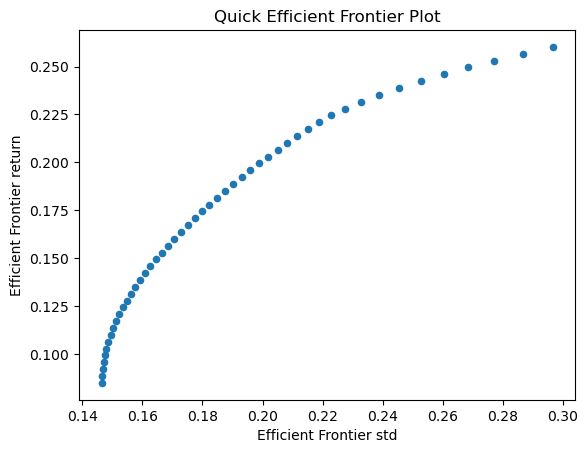

In [7]:
results = portfolio.get_efficient_frontier()
ef_df = pd.DataFrame({"Efficient Frontier return": results[-1], "Efficient Frontier std": results[-2]})
ef_df.plot(kind='scatter', x="Efficient Frontier std", y="Efficient Frontier return", title="Quick Efficient Frontier Plot")
ef_df.head()


To facilitate the comparison and visualization of efficient portfolios, I generated portfolios with random weight combinations.\
I opted for an exponential distribution to allow for the possibility of assigning higher weights to certain assets.\
Furthermore, I intentionally assigned a value of 0 (or the minimum value) to approximately 20% of the assets.

```
returns, stds, results = [], [], []
for _ in tqdm(range(trials)): # trials = 5000
  # Generate random weights
  weights = np.random.exponential(scale=0.5, size=self.num_assets)

  # Randomly select indices to change to minimum weigh
  indices_to_change = random.sample(range(len(weights)), np.random.randint(1, int(len(weights)*0.8)))

  # Create a new list with elements changed to minimum weight
  weights = [self.minimum_weight if i in indices_to_change else elem for i, elem in enumerate(weights)]

  # Normalize to ensure the weights sum to 1
  weights /= np.sum(weights)
```



In [8]:
portfolio.plot_efficient_frontier()

100%|██████████| 5000/5000 [00:01<00:00, 2794.31it/s]


Let's observe how the weights we assign to each asset are distributed.

In [9]:
pd.DataFrame([portfolio.max_sharp_ratio_portfolio()['x'], stock_symbols]).T

0      1
0   0.081537   AAPL
1    0.17351   MSFT
2        0.0  GOOGL
3   0.069078   TSLA
4   0.140629   AMZN
5        0.0    JNJ
6        0.0  BRK-B
7        0.0    JPM
8   0.028017    WMT
9        0.0    DIS
10       0.0     PG
11       0.0      V
12       0.0   PYPL
13       0.0   NFLX
14       0.0    CRM
15       0.0   CSCO
16       0.0   INTC
17       0.0      T
18       0.0     BA
19       0.0     MA
20       0.0    XOM
21       0.0    PEP
22       0.0   ADBE
23       0.0  CMCSA
24       0.0     KO
25       0.0     HD
26  0.311189    UNH
27  0.196039   TMUS

## Explore Results With Different Parameters
Let's experiment with the parameters a bit and observe the effects of altering the risk-free rate and minimum weights.

In [10]:
portfolio.risk_free_rate = 0.05
portfolio.plot_efficient_frontier()
print(f"Max Sharp Ratio Return: {portfolio.portfolio_return(portfolio.max_sharp_ratio_portfolio()['x'])}")


100%|██████████| 5000/5000 [00:01<00:00, 2557.26it/s]


Max Sharp Ratio Return: 0.22535263353114557


In [11]:
portfolio.risk_free_rate = 0.05
portfolio.minimum_weight = 0.005
portfolio.plot_efficient_frontier()
print(f"\n\nMax Sharp Ratio Return: {portfolio.portfolio_return(portfolio.max_sharp_ratio_portfolio()['x'])}\n\n")
pd.DataFrame([portfolio.max_sharp_ratio_portfolio()['x'], stock_symbols]).T

C:\Users\TomerA\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|██████████| 5000/5000 [00:01<00:00, 2587.12it/s]




Max Sharp Ratio Return: 0.21347349574041258




0      1
0   0.047989   AAPL
1    0.18421   MSFT
2      0.005  GOOGL
3   0.097619   TSLA
4   0.146389   AMZN
5      0.005    JNJ
6      0.005  BRK-B
7      0.005    JPM
8      0.005    WMT
9      0.005    DIS
10     0.005     PG
11     0.005      V
12     0.005   PYPL
13     0.005   NFLX
14     0.005    CRM
15     0.005   CSCO
16     0.005   INTC
17     0.005      T
18     0.005     BA
19     0.005     MA
20     0.005    XOM
21     0.005    PEP
22     0.005   ADBE
23     0.005  CMCSA
24     0.005     KO
25     0.005     HD
26  0.276537    UNH
27  0.137256   TMUS

## Capital Market Line (CML)
The Capital Market Line (CML) is a fundamental concept in finance that showcases the optimal blend of risk and return in investment portfolios. It is a theoretical framework encompassing all portfolios that strike an optimal balance between the risk-free rate of return and the market portfolio, comprised of risky assets. According to the Capital Asset Pricing Model (CAPM), in a state of equilibrium, all investors are inclined to position themselves along the CML by either borrowing or lending at the risk-free rate. This strategic positioning allows investors to maximize their return for a given level of risk, ensuring an efficient risk-return trade-off.

<br>

**The Capital Market Line (CML) equation:**
\begin{align}
R_i &= R_f + \frac{E[R_m] - R_f}{\sigma_m} \cdot \sigma_i
\end{align}

Where:
- $R_i$ = Expected return of a portfolio or asset $i$ \\
- $R_f$ = Risk-free rate of return \\
- $E[R_m]$ = Expected return of the market portfolio \\
- $\sigma_m$ = Standard deviation of the market portfolio \\
- $\sigma_i$ = Standard deviation of portfolio or asset $i$

<br>

**The Capital Asset Pricing Model (CAPM) equation:**
\begin{align}
E[R_i] &= R_f + \beta_i \cdot (E[R_m] - R_f)
\end{align}

Where:
- $E[R_i]$ = Expected return of portfolio or asset $i$ \\
- $R_f$ = Risk-free rate of return \\
- $\beta_i$ = Beta of portfolio or asset $i$ \\
- $E[R_m]$ = Expected return of the market portfolio


<br>

In the code, I create the line (CML) by adjusting the allocation of weights between the portfolio with the maximum Sharpe ratio and the risk-free asset, resulting in a new portfolio with its own return and standard deviation. It's worth noting that the risk-free asset has a standard deviation of 0.

Additionally, I enable the option to leverage the new portfolio, allowing for short positions on the risk-free asset (either borrowing or taking a loan) and potentially increasing the allocation to the portfolio with the maximum Sharpe ratio beyond 100%.

```
self.cml = {'returns':[], 'stds':[], 'leverage_returns':[], 'leverage_stds':[]}

for i in np.linspace(0, max_leverage, 60):
  Wp = i
  Wrf = 1-Wp
  if i <= 1:
    self.cml['returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
    self.cml['stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
  else:
    self.cml['leverage_returns'].append(Wp * max_sharp_return + Wrf * self.risk_free_rate)
    self.cml['leverage_stds'].append(Wp * max_sharp_std)# + Wrf * risk_free_std <- which always be 0
```

In [12]:
portfolio.risk_free_rate = 0.05
portfolio.minimum_weight = 0.005
portfolio.plot_efficient_frontier(with_cml=True)

C:\Users\TomerA\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|██████████| 5000/5000 [00:01<00:00, 2620.47it/s]


In [ ]:
#max_sharp_returns, max_sharp_std, max_sharp_allocation, min_vol_returns, min_vol_std, min_vol_allocation, efficient_frontier_list, target_return_list
efficient_frontier = portfolio.get_efficient_frontier()
efficient_frontier

In [ ]:
returns, stds, results = portfolio.simulate_portfolios(max_r=efficient_frontier[0]*2, max_std=efficient_frontier[1]*2)
returns[:5], stds[:5]

In [5]:
portfolio = Portfolio(df)
portfolio.plot_efficient_frontier()

100%|██████████| 5000/5000 [00:01<00:00, 2769.20it/s]


In [23]:
portfolio = Portfolio(df)
portfolio.plot_efficient_frontier()

100%|██████████| 5000/5000 [00:02<00:00, 2355.75it/s]


In [43]:
portfolio = Portfolio(df, minimum_weight=0.01)
portfolio.plot_efficient_frontier()

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|██████████| 5000/5000 [00:02<00:00, 1741.47it/s]


In [48]:
portfolio = Portfolio(df, risk_free_rate=0.2)
portfolio.plot_efficient_frontier()

100%|██████████| 5000/5000 [00:02<00:00, 2329.06it/s]


In [53]:
print(f"Target return: {efficient_frontier[-2][8]}")

print(f"Standard Deviation (Risk): {portfolio.min_var_portfolio(target_return=efficient_frontier[-2][8])['fun']}")

print(f"Weights: {portfolio.min_var_portfolio(target_return=efficient_frontier[-2][8])['x']}")

Target return: 0.15894329140425173
Standard Deviation (Risk): 0.1595927462290114
Weights: [1.96724652e-01 0.00000000e+00 1.87060929e-01 0.00000000e+00
 4.00206127e-17 5.86749007e-02 2.84603070e-18 0.00000000e+00
 7.22349697e-18 0.00000000e+00 9.64939934e-18 0.00000000e+00
 5.84963395e-02 1.19804340e-17 4.11745208e-02 0.00000000e+00
 1.67550257e-01 1.17274468e-02 1.36010530e-01 1.42580424e-01]


In [95]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

# Define a list of stock symbols
stock_symbols = [#"AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "JNJ", "BRK-B", "JPM", "NVDA",
                 "WMT", "DIS", "PG","V", "PYPL", "NFLX", "CRM", "CSCO", "INTC", "T",
                 "BA", "MA", "XOM", "PEP", "ADBE", "CMCSA", "KO", "HD", "UNH", "TMUS"]
# Define the date range for historical data
start_date = "2015-01-01"
end_date = "2023-10-01"

def get_data(stock_symbols: list, start: str, end: str, period="1d"):
  stock_data = {}

  for symbol in stock_symbols:
      stock = yf.Ticker(symbol)
      stock_history = stock.history(period=period, start=start_date, end=end_date)
      stock_data[symbol] = stock_history

  return pd.DataFrame({symbol: data["Close"] for symbol, data in stock_data.items()})


df = get_data(stock_symbols, start_date, end_date)

In [100]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

def get_data(stock_symbols: list, start: str, end: str, period="1d"):
  stock_data = {}

  for symbol in stock_symbols:
      stock = yf.Ticker(symbol)
      stock_history = stock.history(period=period, start=start_date, end=end_date)
      stock_data[symbol] = stock_history

  # Create a DataFrame with stock prices
  df = pd.DataFrame({symbol: data["Close"] for symbol, data in stock_data.items()})
  returns = df.pct_change() # log???
  mean_returns = returns.mean()
  cov_matrix = returns.cov()
  return mean_returns, cov_matrix, df



# Define a list of stock symbols
stock_symbols = [#"AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "JNJ", "BRK-B", "JPM", "NVDA",
                 "WMT", "DIS", "PG","V", "PYPL", "NFLX", "CRM", "CSCO", "INTC", "T",
                 "BA", "MA", "XOM", "PEP", "ADBE", "CMCSA", "KO", "HD", "UNH", "TMUS"]
# Define the date range for historical data
start_date = "2015-01-01"
end_date = "2023-10-01"

mean_returns, cov_matrix, df = get_data(stock_symbols, start_date, end_date)

In [103]:


def portfolio_return(weights, mean_returns, cov_matrix):
    return np.sum(mean_returns * weights) * 252 #from daily to annually

def portfolio_variance(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))*np.sqrt(252) #from daily to annually

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = portfolio_return(weights, mean_returns, cov_matrix)
    std = portfolio_variance(weights, mean_returns, cov_matrix)
    return returns, std

def get_neg_sharp_ratio(weights, mean_returns, cov_matrix, risk_free_rate = 0):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std

# def get_neg_sharp_ratio(weights, mean_returns, cov_matrix, risk_free_rate = 0):
#     p_returns = portfolio_return(weights, mean_returns, cov_matrix)
#     p_std = portfolio_variance(weights, mean_returns, cov_matrix)
#     return - (p_returns - risk_free_rate) / p_std

def max_sharp_ratio_portfolio(mean_returns, cov_matrix, risk_free_rate = 0, minimum_weight=0):
    "Minimize the negative SR, by altering the weights of the portfolio"
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (minimum_weight, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(get_neg_sharp_ratio,
                      num_assets*[1./num_assets],
                      args=args,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result

max_sharp_ratio_portfolio(mean_returns, cov_matrix)['x']

array([8.74497152e-02, 3.36455039e-16, 3.68737159e-16, 0.00000000e+00,
       1.41054703e-16, 1.30546554e-01, 0.00000000e+00, 0.00000000e+00,
       5.33806940e-16, 0.00000000e+00, 0.00000000e+00, 5.81582537e-02,
       0.00000000e+00, 0.00000000e+00, 1.44027586e-01, 8.21283146e-18,
       0.00000000e+00, 0.00000000e+00, 3.38916508e-01, 2.40901384e-01])

In [ ]:

def min_var_portfolio(mean_returns, cov_matrix, minimum_weight=0):
    """Minimize the portfolio variance by altering the
     weights/allocation of assets in the portfolio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (minimum_weight, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(portfolio_variance,
                      num_assets*[1./num_assets],
                      args=args,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result

In [ ]:

def efficient_frontier(mean_returns, cov_matrix, target_return, minimum_weight=0):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolio_return(x, mean_returns, cov_matrix) - target_return},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (minimum_weight, 1)
    bounds = tuple(bound for asset in range(num_assets))
    eff_frontier = minimize(portfolio_variance,
                            num_assets*[1./num_assets],
                            args=args,
                            method = 'SLSQP',
                            bounds=bounds,
                            constraints=constraints)
    return eff_frontier

In [ ]:
efficient_frontier(mean_returns, cov_matrix, 0.18, 0.0005)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16868490777630848
       x: [ 1.791e-01  5.000e-04 ...  1.886e-01  1.697e-01]
     nit: 14
     jac: [ 1.364e-01  1.522e-01 ...  1.955e-01  1.906e-01]
    nfev: 294
    njev: 14

In [ ]:
def get_results(mean_returns, cov_matrix, risk_free_rate=0, minimum_weight=0):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = max_sharp_ratio_portfolio(mean_returns, cov_matrix, minimum_weight=minimum_weight)
    maxSR_returns, maxSR_std = portfolio_performance(maxSR_Portfolio['x'], mean_returns, cov_matrix)
    #maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=mean_returns.index, columns=['allocation'])
    #maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]

    # Min Volatility Portfolio
    minVol_Portfolio = min_var_portfolio(mean_returns, cov_matrix, minimum_weight=minimum_weight)
    minVol_returns, minVol_std = portfolio_performance(minVol_Portfolio['x'], mean_returns, cov_matrix)
    #minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=mean_returns.index, columns=['allocation'])
    #minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficient_frontier(mean_returns, cov_matrix, target, minimum_weight=minimum_weight)['fun'])
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList,targetReturns

In [ ]:
from tqdm import tqdm
import random
# Simulate portfolios
def simulate_portfolios(mean_returns, cov_matrix, max_r, max_std, trials=5000, minimum_weight=0):
  returns, stds, results = [], [], []
  num_assets = len(mean_returns)
  for _ in tqdm(range(trials)):

    # Generate random weights
    weights = np.random.exponential(scale=0.2, size=num_assets)

    # Randomly select indices to change to 0
    indices_to_change = random.sample(range(len(weights)), np.random.randint(1, int(len(weights)*0.9)))

    # Create a new list with elements changed to 0
    weights = [0 if i in indices_to_change else elem for i, elem in enumerate(weights)]

    # Apply the minimum weight constraint
    weights = minimum_weight + (1 - num_assets * minimum_weight) * (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

    # Normalize to ensure the weights sum to 1
    weights /= np.sum(weights)

    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    if p_return > max_r or p_std > max_std:
      pass
    else:
      returns.append(p_return)
      stds.append(p_std)
      results.append(weights)
  return returns, stds, results


In [ ]:
 maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = get_results(mean_returns, cov_matrix, 0, 0.0005)


In [ ]:
returns, stds, results = simulate_portfolios(mean_returns, cov_matrix, maxSR_returns, maxSR_std*2, 10000, minimum_weight=0.0005)

100%|██████████| 10000/10000 [00:08<00:00, 1153.93it/s]


In [ ]:
import plotly.graph_objects as go
def EF_graph(mean_returns, cov_matrix, returns, stds, risk_free_rate=0, minimum_weight=0):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = get_results(mean_returns, cov_matrix, risk_free_rate, minimum_weight)
    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black'))
    )
    #Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black'))
    )
    #Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[ef_std for ef_std in efficientList],
        y=[target for target in targetReturns],
        line=dict(color='black', width=4, dash='solid')
    )

    # Random Portfolios
    random_portfolios = go.Scatter(
        name='Random Weights Portfolios',
        mode='markers',
        x=stds,
        y=returns,
        line=dict(color='blue', width=0.5)
    )

    data = [MaxSharpeRatio, MinVol, EF_curve,random_portfolios]
    layout = go.Layout(
        title = 'Portfolio Optimisation with the Efficient Frontier',
        yaxis = dict(title='Annualised Return (%)'),
        xaxis = dict(title='Annualised Volatility (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)

    fig = go.Figure(data=data, layout=layout)
    return fig.show()

In [ ]:
EF_graph(mean_returns, cov_matrix, returns, stds, risk_free_rate=0.005, minimum_weight=0.0005)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_cml(risk_free_rate, efficient_frontier):
    """
    Calculate the Capital Market Line (CML).

    Parameters:
    - risk_free_rate: The risk-free rate (e.g., 0.03 for 3%)
    - efficient_frontier: A DataFrame containing the efficient frontier data with columns: 'Return', 'Volatility'

    Returns:
    - cml: A DataFrame containing the CML data with columns: 'Return', 'Volatility'
    """
    cml = efficient_frontier.copy()

    # Calculate the slope (Sharpe Ratio) of the CML
    cml['Slope'] = (cml['Return'] - risk_free_rate) / cml['Volatility']

    # Find the portfolio with the highest Sharpe Ratio (MSRP)
    msrp = cml.iloc[cml['Slope'].idxmax()]

    # Calculate the CML
    cml['CML'] = risk_free_rate + msrp['Slope'] * cml['Volatility']

    return cml

# Example usage:
# Assuming you have efficient frontier data in 'efficient_frontier' DataFrame and a risk-free rate of 0.03 (3%)
risk_free_rate = 0.03
cml_data = calculate_cml(risk_free_rate, efficient_frontier)

# Plot the Efficient Frontier and CML
plt.scatter(efficient_frontier['Volatility'], efficient_frontier['Return'], c=efficient_frontier['Sharpe Ratio'], cmap='YlGnBu', marker='o', label='Efficient Frontier')
plt.plot(cml_data['Volatility'], cml_data['CML'], color='red', linestyle='--', label='Capital Market Line (CML)')
plt.title('Efficient Frontier and Capital Market Line (CML)')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.show()

In [ ]:
# Calculate the covariance matrix
returns = df.pct_change().dropna()

cov_matrix = returns.cov()

# Calculate the expected returns
expected_returns = returns.mean()

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define bounds for weights (0 <= weight <= 1)
bounds = tuple((0.02, 1) for _ in range(len(stock_symbols)))

# Define the objective function for portfolio optimization (Minimize Portfolio Variance)
def portfolio_variance(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Initial guess for weights (equal weights)
initial_weights = np.array([1.0 / len(stock_symbols) for _ in range(len(stock_symbols))])

# Optimize for Minimum Variance Portfolio
min_variance_portfolio = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Calculate the Minimum Variance Portfolio's return and volatility
min_variance_return = np.sum(expected_returns * min_variance_portfolio.x)
min_variance_volatility = portfolio_variance(min_variance_portfolio.x)

# Calculate the Sharpe Ratio for the Minimum Variance Portfolio (risk-free rate assumed to be 0)
rf_rate = 0.0
sharpe_ratio_min_variance = (min_variance_return - rf_rate) / min_variance_volatility

# Optimize for Maximum Sharpe Ratio Portfolio
def negative_sharpe_ratio(weights):
    return -((np.sum(expected_returns * weights) - rf_rate) / np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))

max_sharpe_portfolio = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Calculate the Maximum Sharpe Ratio Portfolio's return and volatility
max_sharpe_return = np.sum(expected_returns * max_sharpe_portfolio.x)
max_sharpe_volatility = portfolio_variance(max_sharpe_portfolio.x)

# Print the results
print("Minimum Variance Portfolio:")
print("Weights:", min_variance_portfolio.x)
print("Expected Return:", min_variance_return)
print("Volatility:", min_variance_volatility)
print("Sharpe Ratio:", sharpe_ratio_min_variance)

print("\nMaximum Sharpe Ratio Portfolio:")
print("Weights:", max_sharpe_portfolio.x)
print("Expected Return:", max_sharpe_return)
print("Volatility:", max_sharpe_volatility)
print("Sharpe Ratio:", -max_sharpe_portfolio.fun)

Minimum Variance Portfolio:
Weights: [0.02       0.02       0.06462086 0.29010896 0.02       0.07548087
 0.33721845 0.02974927 0.05586067 0.08696092]
Expected Return: 0.0005010151499223463
Volatility: 0.010427398990371128
Sharpe Ratio: 0.0480479504414278

Maximum Sharpe Ratio Portfolio:
Weights: [0.02       0.03806828 0.02       0.02       0.22258751 0.02
 0.02       0.02       0.35439726 0.26494695]
Expected Return: 0.0009023271447598424
Volatility: 0.013138905606628297
Sharpe Ratio: 0.0686759743752659


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


100%|██████████| 50000/50000 [00:15<00:00, 3265.71it/s]


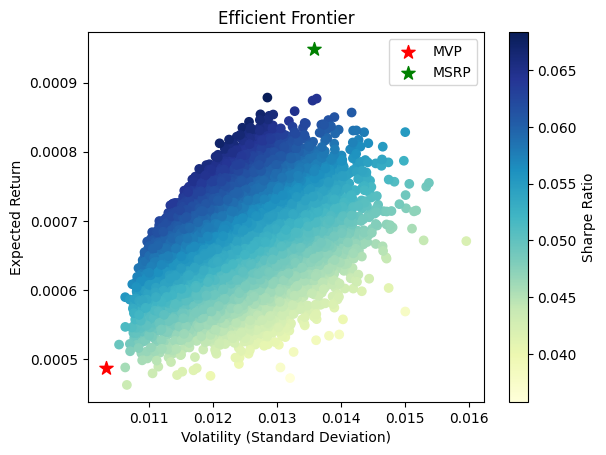

In [ ]:
from tqdm import tqdm
# Calculate daily returns
returns = df.pct_change().dropna()

# Calculate the covariance matrix
cov_matrix = returns.cov()

# Calculate the expected returns
expected_returns = returns.mean()

# Number of portfolios to simulate
num_portfolios = 50000

# Initialize variables to store portfolio results
results = np.zeros((4, num_portfolios))  # 4 rows: Return, Volatility, Sharpe Ratio, Weights
results = []

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define bounds for weights (0 <= weight <= 1)
bounds = tuple((0, 1) for _ in range(len(stock_symbols)))

# Define the objective function for portfolio optimization (Minimize Portfolio Variance)
def portfolio_variance(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Simulate portfolios
for i in tqdm(range(num_portfolios)):
    result = {}

    # Generate random weights
    weights = np.random.rand(len(stock_symbols))
    weights /= np.sum(weights)

    # Calculate portfolio statistics
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_volatility = portfolio_variance(weights)
    sharpe_ratio = portfolio_return / portfolio_volatility
    # Store results
    # results[0, i] = portfolio_return
    # results[1, i] = portfolio_volatility
    # results[2, i] = sharpe_ratio
    # results[3, i] = weights # Store weights as a string
    result['Return'] = portfolio_return
    result['Volatility'] = portfolio_volatility
    result['Sharpe Ratio'] = sharpe_ratio
    result['Weights'] = weights
    results.append(result)

# Convert results to a DataFrame
# portfolios = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio', 'Weights'])
portfolios = pd.DataFrame(results)
# Find the Minimum Variance Portfolio (MVP)
# min_variance_portfolio = portfolios.iloc[portfolios['Volatility'].idxmin()]

# # Find the Maximum Sharpe Ratio Portfolio (MSRP)
# max_sharpe_portfolio = portfolios.iloc[portfolios['Sharpe Ratio'].idxmax()]

# # Convert weights from string to a numpy array
# min_variance_portfolio['Weights'] = np.array(min_variance_portfolio['Weights'])
# max_sharpe_portfolio['Weights'] = np.array(max_sharpe_portfolio['Weights'])

# Plot the Efficient Frontier
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(min_variance_portfolio['Volatility'], min_variance_portfolio['Return'], c='red', marker='*', s=100, label='MVP')
# plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], c='green', marker='*', s=100, label='MSRP')
plt.scatter(min_variance_volatility, min_variance_return, c='red', marker='*', s=100, label='MVP')
plt.scatter(max_sharpe_volatility, max_sharpe_return, c='green', marker='*', s=100, label='MSRP')
plt.legend()
plt.show()

# # Display MVP and MSRP portfolios
# print("Minimum Variance Portfolio (MVP):")
# print("Weights:", min_variance_portfolio['Weights'])
# print("Expected Return:", min_variance_portfolio['Return'])
# print("Volatility:", min_variance_portfolio['Volatility'])
# print("Sharpe Ratio:", min_variance_portfolio['Sharpe Ratio'])

# print("\nMaximum Sharpe Ratio Portfolio (MSRP):")
# print("Weights:", max_sharpe_portfolio['Weights'])
# print("Expected Return:", max_sharpe_portfolio['Return'])
# print("Volatility:", max_sharpe_portfolio['Volatility'])
# print("Sharpe Ratio:", max_sharpe_portfolio['Sharpe Ratio'])

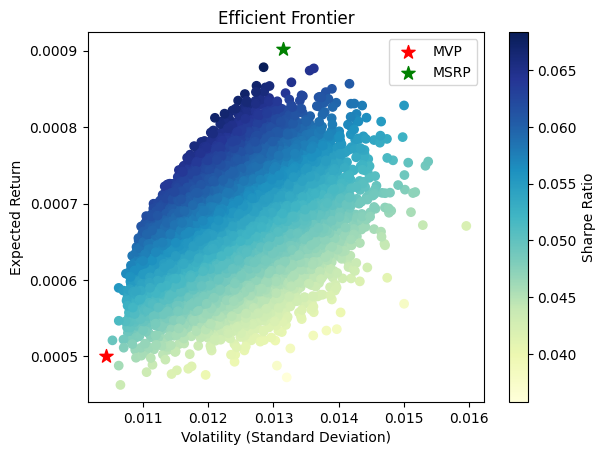

In [ ]:

# Plot the Efficient Frontier
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(min_variance_portfolio['Volatility'], min_variance_portfolio['Return'], c='red', marker='*', s=100, label='MVP')
# plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], c='green', marker='*', s=100, label='MSRP')
plt.scatter(min_variance_volatility, min_variance_return, c='red', marker='*', s=100, label='MVP')
plt.scatter(max_sharpe_volatility, max_sharpe_return, c='green', marker='*', s=100, label='MSRP')
plt.legend()
plt.show()

In [ ]:
from scipy.optimize import minimize

def minimum_variance(ret):
    def find_port_variance(weights):
        # this is actually std
        cov = ret.cov()
        port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return port_var

    def weight_cons(weights):
        return np.sum(weights) - 1


    bounds_lim = [(0, 1) for x in range(len(ret.columns))] # change to (-1, 1) if you want to short
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    constraint = {'type': 'eq', 'fun': weight_cons}

    optimal = minimize(fun=find_port_variance,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])

In [ ]:
def max_sharpe(ret):
    def sharpe_func(weights):
        hist_mean = ret.mean(axis=0).to_frame()
        hist_cov = ret.cov()

        port_ret = np.dot(weights.T, hist_mean.values) * 250
        port_std = np.sqrt(np.dot(weights.T, np.dot(hist_cov, weights)) * 250)
        return -1 * port_ret / port_std

    def weight_cons(weights):
        return np.sum(weights) - 1


    bounds_lim = [(0, 1) for x in range(len(ret.columns))] # change to (-1, 1) if you want to short
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    constraint = {'type': 'eq', 'fun': weight_cons}

    optimal = minimize(fun=sharpe_func,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 2. Calculate daily returns
returns = df.pct_change().dropna()

# 3. Create random portfolios
num_portfolios = 50000
results = np.zeros((3, num_portfolios))  # 3 rows: Return, Volatility, Sharpe Ratio

for i in range(num_portfolios):
    weights = np.random.random(len(returns.columns))
    weights /= np.sum(weights)

    # Calculate portfolio returns and standard deviation
    portfolio_return = np.sum(returns.mean() * weights) * 252  # 252 trading days in a year
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

    # Store results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = portfolio_return / portfolio_stddev  # Sharpe Ratio

# Convert results to a DataFrame
portfolios = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])

# 4. Find the portfolio with the maximum Sharpe Ratio (Tangency Portfolio)
max_sharpe_portfolio = portfolios.iloc[portfolios['Sharpe Ratio'].idxmax()]

# 5. Plot the Efficient Frontier
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=portfolios['Sharpe Ratio'], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], c='red', marker='*', s=100)
plt.show()

# Display the portfolio with the maximum Sharpe Ratio
print("Max Sharpe Portfolio:")
print(max_sharpe_portfolio)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/nump

TypeError: ignored

In [ ]:
df

AAPL        MSFT       GOOGL        TSLA  \
Date                                                                        
2015-01-02 00:00:00-05:00   24.498682   40.534847   26.477501   14.620667   
2015-01-05 00:00:00-05:00   23.808514   40.162094   25.973000   14.006000   
2015-01-06 00:00:00-05:00   23.810759   39.572624   25.332001   14.085333   
2015-01-07 00:00:00-05:00   24.144640   40.075397   25.257500   14.063333   
2015-01-08 00:00:00-05:00   25.072325   41.254345   25.345501   14.041333   
...                               ...         ...         ...         ...   
2023-09-25 00:00:00-04:00  176.080002  317.540009  131.110001  246.990005   
2023-09-26 00:00:00-04:00  171.960007  312.140015  128.570007  244.119995   
2023-09-27 00:00:00-04:00  170.429993  312.790009  130.539993  240.500000   
2023-09-28 00:00:00-04:00  170.690002  313.640015  132.309998  246.380005   
2023-09-29 00:00:00-04:00  171.210007  315.750000  130.860001  250.220001   

                                 AMZN  FB         JNJ       BRK-B         JPM  \
Date                                                                            
2015-01-02 00:00:00-05:00   15.426000 NaN   82.477379  149.169998   49.209713   
2015-01-05 00:00:00-05:00   15.109500 NaN   81.901352  147.000000   47.681988   
2015-01-06 00:00:00-05:00   14.764500 NaN   81.498894  146.839996   46.445629   
2015-01-07 00:00:00-05:00   14.921000 NaN   83.298065  148.880005   46.516521   
2015-01-08 00:00:00-05:00   15.023000 NaN   83.953003  151.369995   47.555988   
...                               ...  ..         ...         ...         ...   
2023-09-25 00:00:00-04:00  131.270004 NaN  160.259995  361.709991  146.449997   
2023-09-26 00:00:00-04:00  125.980003 NaN  159.020004  359.420013  144.929993   
2023-09-27 00:00:00-04:00  125.980003 NaN  157.110001  357.779999  145.779999   
2023-09-28 00:00:00-04:00  125.980003 NaN  156.880005  357.059998  147.589996   
2023-09-29 00:00:00-04:00  127.120003 NaN  155.750000  350.299988  145.020004   

                                    V  ...          BA          MA  \
Date                                   ...                           
2015-01-02 00:00:00-05:00   62.381374  ...  113.657219   81.149429   
2015-01-05 00:00:00-05:00   61.004391  ...  112.870071   78.866844   
2015-01-06 00:00:00-05:00   60.611298  ...  111.540642   78.696373   
2015-01-07 00:00:00-05:00   61.423370  ...  113.272354   79.920502   
2015-01-08 00:00:00-05:00   62.247208  ...  115.275284   81.163673   
...                               ...  ...         ...         ...   
2023-09-25 00:00:00-04:00  233.360001  ...  198.779999  402.489990   
2023-09-26 00:00:00-04:00  229.649994  ...  195.639999  395.380005   
2023-09-27 00:00:00-04:00  229.500000  ...  195.460007  395.480011   
2023-09-28 00:00:00-04:00  231.660004  ...  190.429993  399.440002   
2023-09-29 00:00:00-04:00  230.009995  ...  191.679993  395.910004   

                                  XOM         PEP        ADBE      CMCSA  \
Date                                                                       
2015-01-02 00:00:00-05:00   62.658443   73.413628   72.339996  23.947241   
2015-01-05 00:00:00-05:00   60.943977   72.861710   71.980003  23.458870   
2015-01-06 00:00:00-05:00   60.620010   72.309792   70.529999  23.152847   
2015-01-07 00:00:00-05:00   61.234234   74.424217   71.110001  23.131887   
2015-01-08 00:00:00-05:00   62.253460   75.776817   72.919998  23.634933   
...                               ...         ...         ...        ...   
2023-09-25 00:00:00-04:00  116.230003  174.330002  511.600006  44.869999   
2023-09-26 00:00:00-04:00  116.410004  172.520004  506.299988  44.240002   
2023-09-27 00:00:00-04:00  120.199997  169.570007  502.600006  44.599998   
2023-09-28 00:00:00-04:00  119.470001  169.500000  504.670013  44.860001   
2023-09-29 00:00:00-04:00  117.580002  169.440002  509.899994  44.340000   

                                  KO          HD         UNH        TMUS  
Da